### 0. Initialisation

In [97]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import model_selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error


In [98]:
DATA_IN_FOLDER = 'C:/prairie/projet8-1/Immothep/data/cleaned/'

### 1. Exploratory Data Analysis

In [99]:
#Work with Homes, Sells
data = pd.read_csv(os.path.join(DATA_IN_FOLDER, 'Maison_valeursfoncieres.csv'), encoding='utf-8', sep=';', decimal='.')

data = data[data['Nature mutation'] == 'Vente']

# Check the number of data points in the data set
print(f'number of Homes sold : {len(data)}')
# Check the number of features in the data set
print(f'number of columns : {len(data.columns)}'   )
# Check the data types
print(f'data types : {data.dtypes.unique()}')

print('non numerical columns : ' + str(data.select_dtypes(include=['O']).columns.tolist()))
# Check any number of columns with NaN
print(f'number of columns with any NaN values : {data.isnull().any().sum()} / {len(data.columns)}')
# Check any number of data points with NaN
print(f'number of rows with any NaN values : {data.isnull().any(axis=1).sum()} / {len(data)}')


number of Homes sold : 504623
number of columns : 7
data types : [dtype('O') dtype('int64') dtype('float64')]
non numerical columns : ['Nature mutation']
number of columns with any NaN values : 0 / 7
number of rows with any NaN values : 0 / 504623


### Cleanup limits

min : 0 - max : 1110


Text(0.5, 0.98, 'Surface batie')

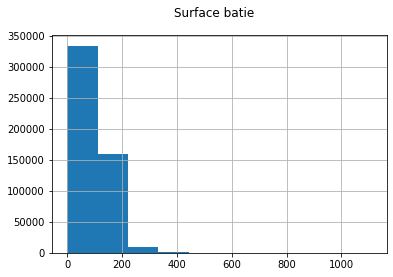

In [100]:
print('min : %s - max : %s' % (data['Surface reelle bati'].min(),data['Surface reelle bati'].max()))
data['Surface reelle bati'].hist()
plt.suptitle('Surface batie')

Text(0.5, 0.98, 'Surface batie')

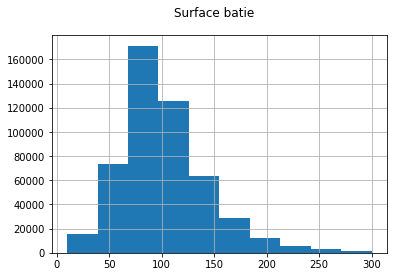

In [101]:
#drop surfaces between 20 and 300
data.drop(data[(data['Surface reelle bati']<10 ) | (data['Surface reelle bati']> 300 )].index, inplace=True)
data['Surface reelle bati'].hist()
plt.suptitle('Surface batie')

min : 0 - max : 67


Text(0.5, 0.98, 'Number of room')

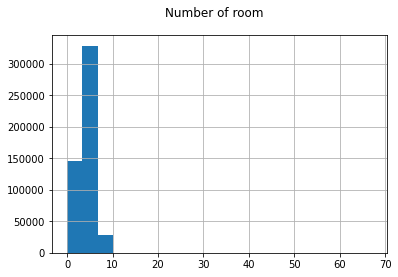

In [102]:
print('min : %s - max : %s' % (data['Nombre pieces principales'].min(),data['Nombre pieces principales'].max()))
data['Nombre pieces principales'].hist(bins=20)
plt.suptitle('Number of room')

Text(0.5, 0.98, 'Number of room')

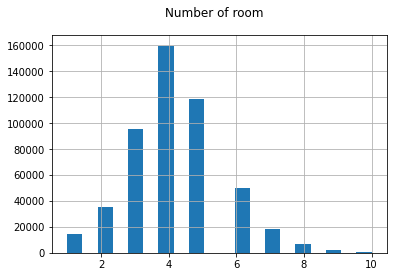

In [103]:
data.drop(data[(data['Nombre pieces principales']> 8 )].index, inplace=True)
data.loc[data['Nombre pieces principales'] == 0] = 1
data['Nombre pieces principales'].hist(bins=20, range=(data['Nombre pieces principales'].min(),data['Nombre pieces principales'].max()))
plt.suptitle('Number of room')

min : 0 - max : 556633


Text(0.5, 0.98, 'Surface terrain')

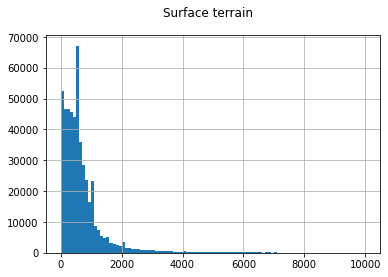

In [104]:
print('min : %s - max : %s' % (data['Surface terrain'].min(),data['Surface terrain'].max()))
data['Surface terrain'].hist(bins=100, range=(0,10000))
plt.suptitle('Surface terrain')

Text(0.5, 0.98, 'Surface terrain')

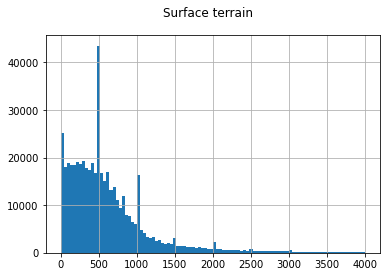

In [105]:
data.drop(data[(data['Surface terrain']> 2500 )].index, inplace=True)
data['Surface terrain'].hist(bins=100, range=(data['Surface terrain'].min(),data['Surface terrain'].max()))
plt.suptitle('Surface terrain')

min : 0.15 - max : 2086000000.0


Text(0.5, 0.98, 'Valeur fonciere')

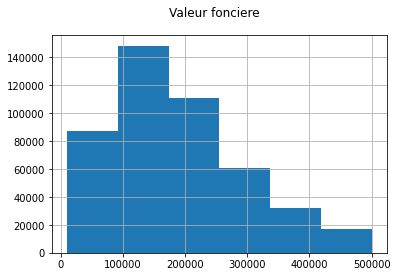

In [106]:
print('min : %s - max : %s' % (data['Valeur fonciere'].min(),data['Valeur fonciere'].max()))
data['Valeur fonciere'].hist(bins=6, range=(10000,500000))
plt.suptitle('Valeur fonciere')

Text(0.5, 0.98, 'Valeur fonciere')

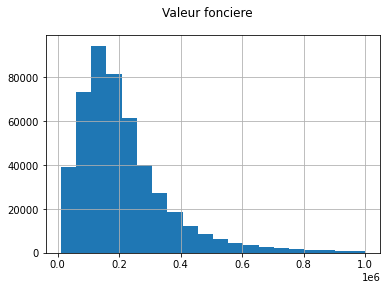

In [107]:
data.drop(data[(data['Valeur fonciere']> 1000000 ) | (data['Valeur fonciere'] < 10000)].index, inplace=True)
data['Valeur fonciere'].hist(bins=20)
plt.suptitle('Valeur fonciere')


<AxesSubplot:>

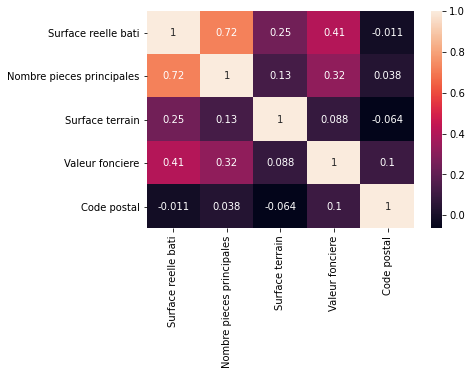

In [108]:

# New correlation matrix
matrix = data[['Surface reelle bati','Nombre pieces principales','Surface terrain','Valeur fonciere','Code postal' ]]
mat_corr = matrix.corr().round(5)
sns.heatmap(data=mat_corr, annot=True)



### 2. Correlations between features and target

In [109]:

features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name

correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]


In [110]:

data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]


,Value
Surface reelle bati vs Valeur fonciere,0.409526
Nombre pieces principales vs Valeur fonciere,0.319007
Code postal vs Valeur fonciere,0.104889
Surface terrain vs Valeur fonciere,0.087813


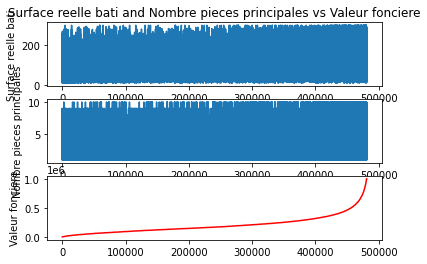

In [111]:

y = data.loc[:,['Surface reelle bati','Nombre pieces principales', target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.title('Surface reelle bati and Nombre pieces principales vs Valeur fonciere')
plt.ylabel('Surface reelle bati')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('Nombre pieces principales')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel('Valeur fonciere')


plt.show()




In [112]:
data.to_csv(os.path.join('C:/prairie/projet8-1/Immothep/data/tmp/', 'toto.csv'), sep=';', index=False )


In [113]:
new_data = data[(data['Code postal'] >= 63000) & (data['Code postal'] < 70000)  ]
print(len(new_data))

13956


In [114]:
regr = LinearRegression()

X =  new_data[['Surface reelle bati','Nombre pieces principales','Surface terrain']].values
y = new_data['Valeur fonciere'].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y ,test_size=0.2)


In [115]:
regr.fit(X_train, y_train)
print(regr.predict(X_test))

[337068.44599284  99416.71410662 280315.18502898 ... 266860.21679228
 208899.15051668 293875.33707516]


In [116]:
regr.score(X_test,y_test)

0.20140365013982087

In [117]:
# Calculate the Root Mean Squared Error
print("RMSE: L'erreur quadratique moyenne est %.2f€"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))


RMSE: L'erreur quadratique moyenne est 159234.09€


In [118]:
# Let's try XGboost algorithm to see if we can get better results
#xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,                    colsample_bytree=1, max_depth=7)

xgb = xgboost.XGBRegressor()
xgb.fit(X_train,y_train)

score = xgb.score(X_train, y_train)  
print("Training score: ", score)


Training score:  0.5593441636057916


In [119]:
scores = cross_val_score(xgb, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())


Mean cross-validation score: 0.23


In [120]:
ypred = xgb.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse*(1/2.0)))


MSE: 25647858206.33
RMSE: 12823929103.17


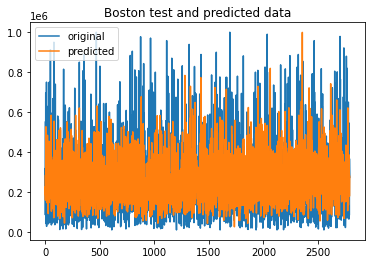

In [121]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")

plt.title("Boston test and predicted data")

plt.legend()
plt.show()

In [122]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

-1.0357557797749224
